# Jumpman23 -- New Market Analysis

Jumpman23 is an on-demand delivery platform connecting “Jumpmen” and customers purchasing a variety of goods. Jumpman23 will send Jumpmen to merchants to purchase and pickup any items requested by the customer. Whenever possible, Jumpman23 will order the requested items ahead to save the Jumpmen time. Each time a Jumpman23 delivery is completed, a record is saved to the Jumpman23 database that contains information about that delivery. Jumpman23 is growing fast and has just launched in its newest market -- New York City.

The CEO of Jumpman23 has just asked you “how are things going in New York”. He has mentioned to you that he’s heard reports of data integrity issues. Please think through the CEO’s ask and present to both the CEO and the CTO, in any format you choose, an analysis of the market. In addition, dive into the reports on data integrity issues and if they indeed exist, outline where they may be and how they may impact the analysis. The CEO is a visual learner, the CTO loves to see code and technical work, and both are obsessed with maps.

You have been provided one small csv file with a sample of data. This file includes:
● Job_ID -- > a unique identifier of a delivery

● Customer_id → a unique identifier for the Jumpman23 customer 

● Jumpman_id → a unique identifier for the Jumpman who completed the delivery

● vehicle_type → The method of transport the Jumpman used to complete the delivery

● pickup_place → The name of the Pickup location

● place_category → A categorization of the Pickup location

● Item_name → the name of the item requested

● Item_quantity → how many of that item was requested

● Item_category_name → categorization provided by merchant, think “appetizers”, “soups” etc

● How_long_it_took_to_order → how long it took to place the order [interval]

● pickup_lat → the coordinates of the pickup location

● pickup_lon → the coordinates of the pickup location

● dropoff_lat → the coordinations of the dropoff location

● dropoff_lon → the coordinations of the dropoff location

● when_the_delivery_started→ localized timestamp representing when the delivery began

● when_the_Jumpman_arrived_at_pickup → localized timestamp representing when theJumpman arrived at the pickup location

● when_the_Jumpman_left_pickup → localized timestamp representing when the Jumpman left the pickup location

● when_the_Jumpman_arrived_at_dropoff → localized timestamp representing when the Jumpman reached the customer


# Initial Hypothesis

Jumpman dataset tracked customers and their deliveries around the city. The answer to How Things are Going in New York can be answered by calculating a few stats and where possible a map:

-Customer Churn

-High Level Totals: Orders / Day, Week, Month

-Top Restaurants

-Top Items By Region

-Top Delivery Drivers

-Delivery Drivers Frequency

-Delivery Drivers Churn

-How fast the deliveries complete from delivery_started to arrived_at_dropoff

-How long pick ups took

-

In [599]:
#import libraries
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 18)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 18)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from mpl_toolkits.basemap import Basemap

from sklearn import feature_selection, linear_model

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from geopy.distance import vincenty

In [600]:
#load data into a dataframe
df = pd.read_csv(os.path.join('analyze_me.csv'))

In [601]:
#lets check that the data loaded correctly
df.head()

delivery_id  customer_id  jumpman_id vehicle_type         pickup_place  \
0      1457973       327168      162381          van            Melt Shop   
1      1377056        64452      104533      bicycle  Prince Street Pizza   
2      1476547        83095      132725      bicycle           Bareburger   
3      1485494       271149      157175      bicycle          Juice Press   
4      1327707       122609      118095      bicycle    Blue Ribbon Sushi   

  place_category                    item_name  item_quantity  \
0       American                     Lemonade            1.0   
1          Pizza        Neapolitan Rice Balls            3.0   
2         Burger                   Bare Sodas            1.0   
3      Juice Bar      OMG! My Favorite Juice!            1.0   
4       Japanese  Spicy Tuna & Tempura Flakes            2.0   

     item_category_name how_long_it_took_to_order  pickup_lat  pickup_lon  \
0             Beverages           00:19:58.582052   40.744607  -73.990742   
1            Munchables           00:25:09.107093   40.723080  -73.994615   
2                Drinks           00:06:44.541717   40.728478  -73.998392   
3   Cold Pressed Juices                       NaN   40.738868  -74.002747   
4  Maki (Special Rolls)           00:03:45.035418   40.726110  -74.002492   

   dropoff_lat  dropoff_lon   when_the_delivery_started  \
0    40.752073   -73.985370  2014-10-26 13:51:59.898924   
1    40.719722   -73.991858   2014-10-16 21:58:58.65491   
2    40.728606   -73.995143  2014-10-28 21:39:52.654394   
3    40.751257   -74.005634  2014-10-30 10:54:11.531894   
4    40.709323   -74.015867  2014-10-10 00:07:18.450505   

  when_the_Jumpman_arrived_at_pickup when_the_Jumpman_left_pickup  \
0                                NaN                          NaN   
1         2014-10-16 22:26:02.120931   2014-10-16 22:48:23.091253   
2         2014-10-28 21:37:18.793405    2014-10-28 21:59:09.98481   
3         2014-10-30 11:04:17.759577   2014-10-30 11:16:37.895816   
4         2014-10-10 00:14:42.702223   2014-10-10 00:25:19.400294   

  when_the_Jumpman_arrived_at_dropoff  
0          2014-10-26 14:52:06.313088  
1          2014-10-16 22:59:22.948873  
2          2014-10-28 22:04:40.634962  
3          2014-10-30 11:32:38.090061  
4          2014-10-10 00:48:27.150595

In [602]:
#lets do some EDA
rows = df.shape[0]

In [603]:
#check for nulls
df.isnull().sum()/rows

delivery_id                            0.000000
customer_id                            0.000000
jumpman_id                             0.000000
vehicle_type                           0.000000
pickup_place                           0.000000
place_category                         0.147585
item_name                              0.205582
item_quantity                          0.205582
item_category_name                     0.205582
how_long_it_took_to_order              0.492228
pickup_lat                             0.000000
pickup_lon                             0.000000
dropoff_lat                            0.000000
dropoff_lon                            0.000000
when_the_delivery_started              0.000000
when_the_Jumpman_arrived_at_pickup     0.091927
when_the_Jumpman_left_pickup           0.091927
when_the_Jumpman_arrived_at_dropoff    0.000000
dtype: float64

Looks like how_long_it_took_to_order is missing in about half the time. We might want to drop / ignore that.
Also noteable is the data has all customer's, ju

In [604]:
df.dtypes

delivery_id                              int64
customer_id                              int64
jumpman_id                               int64
vehicle_type                            object
pickup_place                            object
place_category                          object
item_name                               object
item_quantity                          float64
item_category_name                      object
how_long_it_took_to_order               object
pickup_lat                             float64
pickup_lon                             float64
dropoff_lat                            float64
dropoff_lon                            float64
when_the_delivery_started               object
when_the_Jumpman_arrived_at_pickup      object
when_the_Jumpman_left_pickup            object
when_the_Jumpman_arrived_at_dropoff     object
dtype: object

Need to convert the How Long When columns to Time and Dates

In [605]:
df['when_the_delivery_started'] = pd.to_datetime(df['when_the_delivery_started'])
df['when_the_Jumpman_arrived_at_pickup'] = pd.to_datetime(df['when_the_Jumpman_arrived_at_pickup'])
df['when_the_Jumpman_left_pickup'] = pd.to_datetime(df['when_the_Jumpman_left_pickup'])
df['when_the_Jumpman_arrived_at_dropoff'] = pd.to_datetime(df['when_the_Jumpman_arrived_at_dropoff'])               

In [606]:
df.dtypes[-4:] #almost done

when_the_delivery_started              datetime64[ns]
when_the_Jumpman_arrived_at_pickup     datetime64[ns]
when_the_Jumpman_left_pickup           datetime64[ns]
when_the_Jumpman_arrived_at_dropoff    datetime64[ns]
dtype: object

In [607]:
df['how_long_it_took_to_order'] = pd.to_datetime(df['how_long_it_took_to_order']).dt.minute+pd.to_datetime(df['how_long_it_took_to_order']).dt.second/60

In [608]:
df['how_long_it_took_to_order'][df['how_long_it_took_to_order'].isnull()]

3      NaN
7      NaN
8      NaN
9      NaN
12     NaN
14     NaN
16     NaN
19     NaN
20     NaN
        ..
5962   NaN
5966   NaN
5967   NaN
5969   NaN
5974   NaN
5976   NaN
5978   NaN
5979   NaN
5980   NaN
Name: how_long_it_took_to_order, dtype: float64

In [609]:
df['HOW_LONG_IT_TOOK_TO_DELIVER'] = df['when_the_Jumpman_arrived_at_dropoff'] - df['when_the_delivery_started']

In [612]:
df['HOW_LONG_IT_TOOK_TO_DELIVER'] =  [ (df['HOW_LONG_IT_TOOK_TO_DELIVER'].iloc[i].seconds / 60.) for i in range(len(df['HOW_LONG_IT_TOOK_TO_DELIVER'])) if df['HOW_LONG_IT_TOOK_TO_DELIVER'].iloc[i] != None]

AttributeError: 'numpy.float64' object has no attribute 'seconds'

In [613]:
df.how_long_it_took_to_order #fixed but still a ton of nulls

0       19.966667
1       25.150000
2        6.733333
3             NaN
4        3.750000
5        7.233333
6        4.816667
7             NaN
8             NaN
          ...    
5974          NaN
5975     5.183333
5976          NaN
5977     3.533333
5978          NaN
5979          NaN
5980          NaN
5981     2.283333
5982     9.416667
Name: how_long_it_took_to_order, dtype: float64

In [617]:
df.HOW_LONG_IT_TOOK_TO_DELIVER.max()

340.30000000000001

In [618]:
print 'date range:', df.when_the_Jumpman_arrived_at_dropoff.min().date(), 'to', df.when_the_Jumpman_arrived_at_dropoff.max().date()

date range: 2014-10-01 to 2014-10-30


In [619]:
df.delivery_id.value_counts() #there duplicates orders

1460296    5
1286826    4
1319971    4
1475127    4
1343610    4
1397032    4
1482492    4
1435427    4
1368206    4
          ..
1338519    1
1467554    1
1479832    1
1416345    1
1399676    1
1432665    1
1363103    1
1356960    1
1327104    1
Name: delivery_id, dtype: int64

In [620]:
df.duplicated().sum()

16

In [621]:
#16 duplicate, lets check them out and remove them

In [622]:
df[(df.delivery_id == 1460296) | (df.delivery_id == 1286826)]

delivery_id  customer_id  jumpman_id vehicle_type         pickup_place  \
1353      1286826        81333       31450      bicycle         Lure Fishbar   
2431      1286826        81333       31450      bicycle         Lure Fishbar   
2599      1460296       155145       39202      bicycle  La Esquina Taqueria   
2601      1286826        81333       31450      bicycle         Lure Fishbar   
3510      1460296       155145       39202      bicycle  La Esquina Taqueria   
3796      1460296       155145       39202      bicycle  La Esquina Taqueria   
4056      1460296       155145       39202      bicycle  La Esquina Taqueria   
4353      1286826        81333       31450      bicycle         Lure Fishbar   
4487      1460296       155145       39202      bicycle  La Esquina Taqueria   

     place_category                            item_name  item_quantity  \
1353        Seafood                          Eel Avocado            1.0   
2431        Seafood                           Sea Urchin            1.0   
2599            NaN                               Bistec            1.0   
2601        Seafood                                 Toro            1.0   
3510            NaN                             Tortilla            1.0   
3796            NaN  Chips & La Esquina's Own Salsa Roja            1.0   
4056            NaN                          Canned Soda            1.0   
4353        Seafood                       Salmon Tartare            1.0   
4487            NaN                    Elotes Callejeros            1.0   

      item_category_name             ...              pickup_lat  pickup_lon  \
1353  Rolls: Cut or Hand             ...               40.724635  -73.998402   
2431     Sushi & Sashimi             ...               40.724635  -73.998402   
2599               Tacos             ...               40.721354  -73.997525   
2601     Sushi & Sashimi             ...               40.724635  -73.998402   
3510               Soups             ...               40.721354  -73.997525   
3796              Plates             ...               40.721354  -73.997525   
4056         Cold Drinks             ...               40.721354  -73.997525   
4353   Dinner Appetizers             ...               40.724635  -73.998402   
4487               Sides             ...               40.721354  -73.997525   

      dropoff_lat  dropoff_lon  when_the_delivery_started  \
1353    40.735667   -73.992730 2014-10-03 17:09:45.858769   
2431    40.735667   -73.992730 2014-10-03 17:09:45.858769   
2599    40.736889   -73.983087 2014-10-26 16:55:46.106588   
2601    40.735667   -73.992730 2014-10-03 17:09:45.858769   
3510    40.736889   -73.983087 2014-10-26 16:55:46.106588   
3796    40.736889   -73.983087 2014-10-26 16:55:46.106588   
4056    40.736889   -73.983087 2014-10-26 16:55:46.106588   
4353    40.735667   -73.992730 2014-10-03 17:09:45.858769   
4487    40.736889   -73.983087 2014-10-26 16:55:46.106588   

     when_the_Jumpman_arrived_at_pickup when_the_Jumpman_left_pickup  \
1353         2014-10-03 17:20:15.995078   2014-10-03 17:40:35.580467   
2431         2014-10-03 17:20:15.995078   2014-10-03 17:40:35.580467   
2599         2014-10-26 17:06:24.099110   2014-10-26 17:15:44.699287   
2601         2014-10-03 17:20:15.995078   2014-10-03 17:40:35.580467   
3510         2014-10-26 17:06:24.099110   2014-10-26 17:15:44.699287   
3796         2014-10-26 17:06:24.099110   2014-10-26 17:15:44.699287   
4056         2014-10-26 17:06:24.099110   2014-10-26 17:15:44.699287   
4353         2014-10-03 17:20:15.995078   2014-10-03 17:40:35.580467   
4487         2014-10-26 17:06:24.099110   2014-10-26 17:15:44.699287   

     when_the_Jumpman_arrived_at_dropoff HOW_LONG_IT_TOOK_TO_DELIVER  
1353          2014-10-03 17:51:37.505765                   41.850000  
2431          2014-10-03 17:51:37.505765                   41.850000  
2599          2014-10-26 17:26:44.885842                   30.966667  
2601          2014-10-03 17:51:37.505

In [623]:
# df[(df.pickup_place == 'Dunkin Donuts') | (df.pickup_place == "Dunkin' Donuts")]

Some of the duplicates are because the item's are individually listed. We could fix these but after noticing that item quantity is often blank its probably best just to drop the mall together to save time

In [624]:
df_drop = df[df.duplicated() == True]

In [625]:
df = df.drop_duplicates()

In [626]:
#df.reindex().iloc[742]

In [627]:
df.duplicated().sum()

0

In [628]:
#now that there are no duplicates, we can set the index delivery id

In [629]:
#df.set_index(['delivery_id'],inplace='True')

In [630]:
#are there eventful deliveries in every row? 

In [631]:
df[(df.item_quantity == 0)].shape[0] #yes

0

In [632]:
df.pickup_place.iloc[742]

'16 Handles'

In [633]:
#most common transporter?

In [634]:
sum_df = pd.DataFrame(df.vehicle_type.value_counts())
vehicle_type_df = sum_df[ ['vehicle_type'] ].\
    sort_values(by = 'vehicle_type', ascending = False)

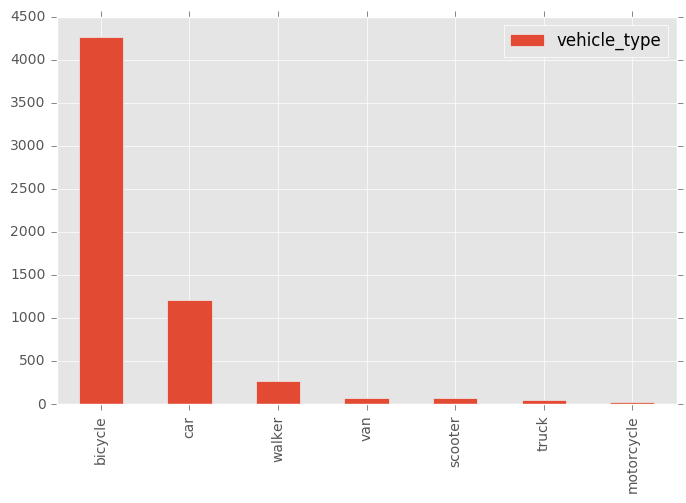

In [635]:
vehicle_type_df.plot(kind = 'bar', figsize = (8, 5))

In [636]:
#Bicyle is the most common but does that mean that they are faster or make less pickups by average?

In [637]:
df.pickup_place.value_counts() #New York? Also, people love shake shack 

Shake Shack                   310
Momofuku Milk Bar             186
The Meatball Shop             180
Blue Ribbon Sushi             151
sweetgreen                    148
Blue Ribbon Fried Chicken     132
Whole Foods Market            119
Parm                          102
RedFarm Broadway               93
                             ... 
The MasalaWala                  1
Moti Mahal Delux                1
Chelsea Wine Country            1
AG Kitchen                      1
Lady M Cake Boutique            1
Abracadabra NYC                 1
Il Cantinori                    1
Lili's Noodle Shop & Grill      1
Manhattan Wardrobe Supply       1
Name: pickup_place, dtype: int64

In [638]:
#cleanup Place names

In [639]:
df['pickup_place'] = df.pickup_place.apply(lambda pickup_place: pickup_place.strip().upper())

In [640]:
df.place_category.value_counts()

Italian               500
Burger                450
Japanese              433
American              403
Chinese               332
Dessert               315
Sushi                 253
Salad                 205
Grocery Store         187
                     ... 
German                  4
Kids & Baby             3
Beauty Supply           2
African                 1
Book Store              1
Pet Supplies Store      1
Art Store               1
Restaurant              1
Clothing                1
Name: place_category, dtype: int64

In [641]:
df.columns#lets aggregate by place and quantity

Index([u'delivery_id', u'customer_id', u'jumpman_id', u'vehicle_type',
       u'pickup_place', u'place_category', u'item_name', u'item_quantity',
       u'item_category_name', u'how_long_it_took_to_order', u'pickup_lat',
       u'pickup_lon', u'dropoff_lat', u'dropoff_lon',
       u'when_the_delivery_started', u'when_the_Jumpman_arrived_at_pickup',
       u'when_the_Jumpman_left_pickup', u'when_the_Jumpman_arrived_at_dropoff',
       u'HOW_LONG_IT_TOOK_TO_DELIVER'],
      dtype='object')

In [649]:
set(df.pickup_place) #need some cleanup

{'$10 BLUE RIBBON FRIED CHICKEN SANDWICH',
 "'ESSEN",
 "'WICHCRAFT",
 '11TH STREET CAFE',
 '12 CHAIRS',
 '143 READE STREET',
 '158',
 '16 EAST 11TH STREET',
 '16 HANDLES',
 '16 HANDLES - CHELSEA',
 '16 HANDLES - EAST VILLAGE',
 '16 HANDLES - MURRAY HILL',
 '16 HANDLES - UES 2ND AVE',
 '16 HANDLES - UWS AMSTERDAM',
 '16 HANDLES - UWS BROADWAY',
 '177 EAST 75TH ST',
 '220 EAST 23RD STREET',
 '24 CENTRAL PARK SOUTH',
 '25 BROADWAY',
 '29 W 57TH ST',
 '299 EAST 11TH NYC',
 '2ND AVE DELI',
 '3 GUYS',
 '3 GUYS RESTAURANT',
 '30 WALL STREET',
 '300 EAST 85TH, AMERICA',
 '300 NORTH END AVE AND WARREN',
 '384 BROOME ST',
 '400 FIFTH AVENUE',
 '420 EAST 72ND ST.',
 '456 SHANGHAI CUISINE',
 '460 PARK AVE SOUTH',
 '5 NAPKIN BURGER',
 '511 EAST 80TH ST',
 '514 W 24TH ST',
 '655 PARK AVENUE',
 '67 BURGER',
 '7-ELEVEN',
 '86 STREET PHOTO',
 'A MATTER OF HEALTH',
 'A SALT & BATTERY',
 'ABRACADABRA NYC',
 'ABSOLUTE BAGEL',
 'ADAMS TOBACCO',
 "ADRIENNE'S PIZZA BAR",
 'AG KITCHEN',
 'AGATA & VALENTINA MA

In [650]:
len(df.pickup_place.unique()) #896 different locations, its messy but we can clean later if totally necessary

896

In [651]:
place_by_lat_lon_df = df[ ['pickup_place','pickup_lon','pickup_lat'] ].\
    groupby(['pickup_lon','pickup_lat']).min()

In [652]:
place_by_lat_lon_df.reset_index(inplace=True)

In [653]:
#Write a function to clean up the names
place_by_lat_lon_df
df.columns

Index([u'delivery_id', u'customer_id', u'jumpman_id', u'vehicle_type',
       u'pickup_place', u'place_category', u'item_name', u'item_quantity',
       u'item_category_name', u'how_long_it_took_to_order', u'pickup_lat',
       u'pickup_lon', u'dropoff_lat', u'dropoff_lon',
       u'when_the_delivery_started', u'when_the_Jumpman_arrived_at_pickup',
       u'when_the_Jumpman_left_pickup', u'when_the_Jumpman_arrived_at_dropoff',
       u'HOW_LONG_IT_TOOK_TO_DELIVER'],
      dtype='object')

In [654]:
place_by_lat_lon_df[place_by_lat_lon_df.pickup_lat==df.pickup_lat.iloc[742]][place_by_lat_lon_df.pickup_lon==df.pickup_lon.iloc[742]]['pickup_place'].values[0]

/Users/smarwaha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


'16 HANDLES'

In [655]:
def rename_places():
    new_place_list = []
    for i in range(len(df.pickup_place)):
        mapped_place = place_by_lat_lon_df[place_by_lat_lon_df.pickup_lat==df.pickup_lat.iloc[i]][place_by_lat_lon_df.pickup_lon==df.pickup_lon.iloc[i]]['pickup_place'].values[0]
        current_place = df.pickup_place.iloc[i]
        if mapped_place != current_place:
            new_place_list.append(mapped_place)
        else: new_place_list.append(current_place)
    return new_place_list

In [656]:
pickup_place_clean = rename_places()

/Users/smarwaha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [657]:
df['PICKUP_PLACE_CLEAN'] = pickup_place_clean

In [658]:
len(df.PICKUP_PLACE_CLEAN.unique())

895

In [659]:
len(df.pickup_place.unique()) - len(df.PICKUP_PLACE_CLEAN.unique())

1

In [660]:
df.drop('pickup_place',axis=1,inplace=True)

In [661]:
df.rename(columns={'PICKUP_PLACE_CLEAN':'PICKUP_PLACE'})

delivery_id  customer_id  jumpman_id vehicle_type  place_category  \
0         1457973       327168      162381          van        American   
1         1377056        64452      104533      bicycle           Pizza   
2         1476547        83095      132725      bicycle          Burger   
3         1485494       271149      157175      bicycle       Juice Bar   
4         1327707       122609      118095      bicycle        Japanese   
5         1423142        75169       91932      bicycle          Indian   
6         1334106       101347      124897      bicycle           Sushi   
7         1311619        59161       79847      bicycle          Bakery   
8         1487674        55375      181543      bicycle             NaN   
...           ...          ...         ...          ...             ...   
5974      1379770       243775      138061          car            Shop   
5975      1475459       303211      156557          car           Pizza   
5976      1300266       135451       36664      bicycle       Juice Bar   
5977      1303444       228541      148268      bicycle         Chinese   
5978      1360750       378035      151467      bicycle          Burger   
5979      1348697        96943        3296      bicycle  Middle Eastern   
5980      1274438       355090      153113      bicycle          Burger   
5981      1470282       400983      142140          car      Vietnamese   
5982      1357449       128517      134189          car         Chinese   

                                              item_name  item_quantity  \
0                                              Lemonade            1.0   
1                                 Neapolitan Rice Balls            3.0   
2                                            Bare Sodas            1.0   
3                               OMG! My Favorite Juice!            1.0   
4                           Spicy Tuna & Tempura Flakes            2.0   
5                                         Dum Aloo Gobi            1.0   
6                                       Spicy Tuna Roll            1.0   
7                                       Chocolate Chunk            2.0   
8                                                   NaN            NaN   
...                                                 ...            ...   
5974  Raventos I Blanc L'Hereu Reserva Brut Cava - 2011            1.0   
5975                                    Chicken Fingers            1.0   
5976                                   Red Dragon Fruit            1.0   
5977                Soft & Crunchy Vegetable Fried Rice            1.0   
5978                                       Cheeseburger            1.0   
5979                                         Vegetarian            1.0   
5980                                              Fries            1.0   
5981                                             Ca Tim            1.0   
5982                            Pan-Fried Pork Buns (4)            1.0   

            item_category_name  how_long_it_took_to_order  \
0                    Beverages                  19.966667   
1                   Munchables                  25.150000   
2                       Drinks                   6.733333   
3          Cold Pressed Juices                        NaN   
4         Maki (Special Rolls)                   3.750000   
5       Vegetarian Specialties                   7.233333   
6     Classic Roll & Hand Roll                   4.816667   
7         Cookies and Brownies                        NaN   
8                          NaN                        NaN   
...                        ...                        ...   
5974                 Sparkling                        NaN   
5975  Appetizers & Side Orders                   5.183333   
5976                 Smoothies                        NaN   
5977            Rice & Noodles                   3.533333   
5978                   Burgers                        NaN   
5979                 Cous Cous                  

In [664]:
# all that and I only cleaned 1 value :/

lets find out more about the customers

In [665]:
len(df.customer_id.unique())

3192

# 3192 Customers

In [666]:
df.customer_id.value_counts()

369272    28
52832     23
275689    17
91817     16
125123    16
58898     16
100889    14
250494    13
115610    13
          ..
158331     1
279895     1
38336      1
225912     1
250484     1
295538     1
359025     1
354923     1
376836     1
Name: customer_id, dtype: int64

In [667]:
len(df.customer_id.value_counts()[df.customer_id.value_counts() ==1])

1942

In [668]:
len(df.customer_id.value_counts()[df.customer_id.value_counts() ==1])*1. / len(df.customer_id.value_counts())*1.

0.6083959899749374

# 1942 customers, 60.8% of the customer base only used Jumpman once, and 80.5 bought 2 or less

In [669]:
sum_df_cust = pd.DataFrame(df.customer_id.value_counts())
customer_id_df = sum_df_cust[ ['customer_id'] ].\
    sort_values(by = 'customer_id', ascending = False)

In [670]:
customer_churn = pd.DataFrame(customer_id_df.customer_id.value_counts()/len(customer_id_df))

In [671]:
customer_churn.rename(columns = {'customer_id': 'purchase_freq'}, inplace = True)

In [672]:
customer_churn.sort_index(inplace=True)

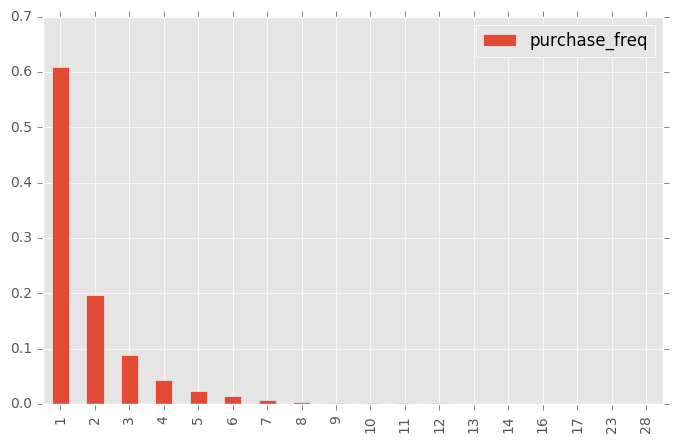

In [673]:
customer_churn.plot(kind='bar', figsize = (8, 5))

In [674]:
#vincenty(coord_1, coord_2).miles

In [675]:
df['PICKUP_LAT_LON'] = zip(df.pickup_lat, df.pickup_lon)

In [676]:
df['DROPOFF_LAT_LON'] = zip(df.dropoff_lat, df.dropoff_lon)

In [677]:
df['DISTANCE']=[vincenty(df.PICKUP_LAT_LON.iloc[i],df.DROPOFF_LAT_LON.iloc[i]).miles for i in range(len(df))]

In [679]:
df['DISTANCE'].describe()

count    5967.000000
mean        1.140837
std         0.984621
min         0.009307
25%         0.483406
50%         0.849364
75%         1.448265
max         7.768819
Name: DISTANCE, dtype: float64

In [680]:
ny_lat_max = 40.9176
ny_lat_min = 40.5774
ny_lon_max = -73.7004
ny_lon_min = -74.15

In [681]:
lat_center = df.pickup_lat.mean()

In [682]:
lon_center = df.pickup_lon.mean()

In [683]:
df.columns

Index([u'delivery_id', u'customer_id', u'jumpman_id', u'vehicle_type',
       u'place_category', u'item_name', u'item_quantity',
       u'item_category_name', u'how_long_it_took_to_order', u'pickup_lat',
       u'pickup_lon', u'dropoff_lat', u'dropoff_lon',
       u'when_the_delivery_started', u'when_the_Jumpman_arrived_at_pickup',
       u'when_the_Jumpman_left_pickup', u'when_the_Jumpman_arrived_at_dropoff',
       u'HOW_LONG_IT_TOOK_TO_DELIVER', u'PICKUP_PLACE_CLEAN',
       u'PICKUP_LAT_LON', u'DROPOFF_LAT_LON', u'DISTANCE'],
      dtype='object')

In [684]:
sum_df_jump = pd.DataFrame(df.jumpman_id.value_counts())
jumpman_id_df = sum_df_jump[ ['jumpman_id'] ].\
    sort_values(by = 'jumpman_id', ascending = False)

In [685]:
jumpman_churn = pd.DataFrame(jumpman_id_df.jumpman_id.value_counts()/len(jumpman_id_df))

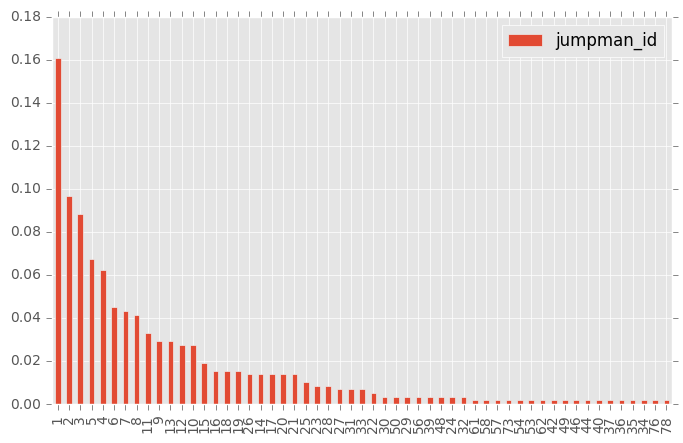

In [686]:
jumpman_churn.plot(kind='bar', figsize = (8, 5))

In [687]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# start the map, using hardcoded lat / long coordinates
#m = Basemap(projection='merc', llcrnrlat=ny_lat_min,urcrnrlat=ny_lat_max, llcrnrlon=ny_lon_min,urcrnrlon=ny_lon_max,lat_ts=20,resolution='c')
#m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            #llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
#m = Basemap(projection='merc',llcrnrlat=40.55,urcrnrlat=40.82,\
#            llcrnrlon=-74.1, urcrnrlon=-73.82, lat_ts=40.5,resolution='f')
#m.drawmapboundary(fill_color='#85A6D9')
#m.drawcoastlines(color='#6D5F47', linewidth=.4)
#m.drawrivers(color='#6D5F47', linewidth=.4)
#m.fillcontinents(color='white',lake_color='#85A6D9')
#plt.show()    

#m.pcolormesh()
# compute map projection coordinates
# where lons and lats are series...
# they were in a weird format in this exercise, this was some munging of them
#x,y = m(lons.values / 100 * -1, lats.values / 100)
# where pts are the data points
#m.pcolormesh(x,y, pts, cmap=plt.cm.viridis, vmin=0, vmax=2, shading='flat')

In [688]:
west, south, east, north = -74.26, 40.50, -73.70, 40.92
#m = Basemap(projection='merc',llcrnrlat=south, urcrnrlat=north,
#            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='f',area_thresh = 0.1)
#m.drawmapboundary(fill_color='#85A6D9')
#m.drawcoastlines(color='#6D5F47', linewidth=.4)
#m.drawrivers(color='#6D5F47', linewidth=.4)
#m.fillcontinents(color='white',lake_color='#85A6D9')
#m.pcolormesh(x,y,z,cmap=plt.cm.viridis, vmin=0, vmax=2, shading='flat')

In [689]:
lat = [round(v,4) for v in df.pickup_lat.values]
lon = [round(v,4) for v in df.pickup_lon.values]
x, y = m(*np.meshgrid(lat, lon))
z = x/x

In [690]:
#from matplotlib import cm
#cs = m.pcolormesh(x,y,data,cmap = my_cmap, vmin = 1)
#x,y = df.pickup_lon.values,df.pickup_lat.values
#pts = df.DISTANCE.values
#m.pcolormesh(x,y,z,cmap=plt.cm.viridis, vmin=0, vmax=2, shading='flat')


In [691]:
df.pickup_lat.values[0]

40.744607141003797

In [692]:
#marker_cluster = folium.MarkerCluster().add_to(jumpman_map)
#for i in range(len(df.pickup_lat)):
#    folium.Marker([df.pickup_lat.iloc[i], df.pickup_lon.iloc[i]].append(marker_cluster))

In [697]:
locations = list(df.PICKUP_LAT_LON)
popups = ['{}'.format(loc) for loc in locations]

In [698]:
from folium import plugins
from folium.plugins import MarkerCluster
jumpman_map = folium.Map(location=[lat_center, lon_center], zoom_start=12)
jumpman_map.add_child(MarkerCluster(locations=locations, popups=popups))
jumpman_map.create_map('jumpman.html')
#jumpman_map

/Users/smarwaha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [722]:
data = zip(df.pickup_lat, df.pickup_lon,df.HOW_LONG_IT_TOOK_TO_DELIVER)

In [723]:
from folium.plugins import HeatMap
jumpman_heatmap_distance = folium.Map(location=[lat_center, lon_center], zoom_start=12)
HeatMap(data).add_to(jumpman_heatmap)
jumpman_heatmap.create_map('jumpman_heatmap.html')
jumpman_heatmap

/Users/smarwaha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [699]:
#ok now that we made a few maps lets get back to data analysis

In [724]:
df.columns

Index([u'delivery_id', u'customer_id', u'jumpman_id', u'vehicle_type',
       u'place_category', u'item_name', u'item_quantity',
       u'item_category_name', u'how_long_it_took_to_order', u'pickup_lat',
       u'pickup_lon', u'dropoff_lat', u'dropoff_lon',
       u'when_the_delivery_started', u'when_the_Jumpman_arrived_at_pickup',
       u'when_the_Jumpman_left_pickup', u'when_the_Jumpman_arrived_at_dropoff',
       u'HOW_LONG_IT_TOOK_TO_DELIVER', u'PICKUP_PLACE_CLEAN',
       u'PICKUP_LAT_LON', u'DROPOFF_LAT_LON', u'DISTANCE'],
      dtype='object')

In [725]:
df.head()

delivery_id  customer_id  jumpman_id vehicle_type place_category  \
0      1457973       327168      162381          van       American   
1      1377056        64452      104533      bicycle          Pizza   
2      1476547        83095      132725      bicycle         Burger   
3      1485494       271149      157175      bicycle      Juice Bar   
4      1327707       122609      118095      bicycle       Japanese   

                     item_name  item_quantity    item_category_name  \
0                     Lemonade            1.0             Beverages   
1        Neapolitan Rice Balls            3.0            Munchables   
2                   Bare Sodas            1.0                Drinks   
3      OMG! My Favorite Juice!            1.0   Cold Pressed Juices   
4  Spicy Tuna & Tempura Flakes            2.0  Maki (Special Rolls)   

   how_long_it_took_to_order    ...     when_the_delivery_started  \
0                  19.966667    ...    2014-10-26 13:51:59.898924   
1                  25.150000    ...    2014-10-16 21:58:58.654910   
2                   6.733333    ...    2014-10-28 21:39:52.654394   
3                        NaN    ...    2014-10-30 10:54:11.531894   
4                   3.750000    ...    2014-10-10 00:07:18.450505   

   when_the_Jumpman_arrived_at_pickup  when_the_Jumpman_left_pickup  \
0                                 NaT                           NaT   
1          2014-10-16 22:26:02.120931    2014-10-16 22:48:23.091253   
2          2014-10-28 21:37:18.793405    2014-10-28 21:59:09.984810   
3          2014-10-30 11:04:17.759577    2014-10-30 11:16:37.895816   
4          2014-10-10 00:14:42.702223    2014-10-10 00:25:19.400294   

   when_the_Jumpman_arrived_at_dropoff HOW_LONG_IT_TOOK_TO_DELIVER  \
0           2014-10-26 14:52:06.313088                   60.100000   
1           2014-10-16 22:59:22.948873                   60.400000   
2           2014-10-28 22:04:40.634962                   24.783333   
3           2014-10-30 11:32:38.090061                   38.433333   
4           2014-10-10 00:48:27.150595                   41.133333   

    PICKUP_PLACE_CLEAN                   PICKUP_LAT_LON  \
0            MELT SHOP   (40.744607141, -73.9907419682)   
1  PRINCE STREET PIZZA   (40.7230795235, -73.994615078)   
2           BAREBURGER  (40.7284782636, -73.9983918374)   
3          JUICE PRESS  (40.7388675545, -74.0027474503)   
4    BLUE RIBBON SUSHI  (40.7261096571, -74.0024918632)   

                   DROPOFF_LAT_LON  DISTANCE  
0  (40.7520725859, -73.9853695546)  0.587239  
1          (40.719722, -73.991858)  0.273175  
2          (40.728606, -73.995143)  0.170769  
3  (40.7512572874, -74.0056337603)  0.868239  
4        (40.7093232, -74.0158665)  1.354525  

[5 rows x 22 columns]

In [728]:
df.jumpman_id.value_counts()

99219     78
104533    76
142394    73
66416     62
61900     61
30743     58
3296      57
20962     56
32580     56
          ..
120726     1
125160     1
170282     1
122573     1
154082     1
158180     1
12779      1
28299      1
176223     1
Name: jumpman_id, dtype: int64

In [745]:
jumpman_df = df[ ['jumpman_id','HOW_LONG_IT_TOOK_TO_DELIVER'] ].\
    groupby(['jumpman_id']).mean()

In [747]:
jumpman_count_df = pd.DataFrame(df.jumpman_id.value_counts())

In [752]:
jumpman_df = jumpman_df.join(jumpman_count_df)

In [762]:
jumpman_vehicle = df[ ['jumpman_id','vehicle_type'] ].\
    groupby(['jumpman_id']).max()

In [764]:
jumpman_df = jumpman_df.join(jumpman_vehicle)

In [767]:
jumpman_dist = df[ ['jumpman_id','DISTANCE'] ].\
    groupby(['jumpman_id']).mean()
jumpman_df = jumpman_df.join(jumpman_dist)
jumpman_df.rename(columns={'jumpman_id':'DELIVERIES','HOW_LONG_IT_TOOK_TO_DELIVER':'AVG_DELIVERY_TIME'},inplace=True)

In [768]:
jumpman_df

AVG_DELIVERY_TIME  DELIVERIES vehicle_type  DISTANCE
jumpman_id                                                      
3296                39.074854          57      bicycle  0.908594
3592                43.858333           2      bicycle  1.805462
3941                31.116667           1      bicycle  0.679207
5935                40.326316          19      bicycle  1.127763
6458                29.158333           2      bicycle  0.620409
6715                25.450000           1      bicycle  0.444494
6873                32.559524          35          car  0.690552
7833                36.662500          28      bicycle  0.864822
8625                54.456667          15      bicycle  1.022457
...                       ...         ...          ...       ...
176701              62.083333           3      bicycle  0.680851
177125              70.800000           1          car  2.729853
177184              71.516667           1          car  1.389734
177231              45.550000           2      bicycle  1.265914
177485              48.366667           1          car  0.328525
177847              45.509524           7      bicycle  1.157070
178325              40.370833           8      bicycle  0.683777
179183              61.466667           1          car  1.105250
181543              20.166667           2      bicycle  1.079073

[578 rows x 4 columns]

In [769]:
jumpman_df.rename(columns={'DISTANCE':'AVG_DISTANCE'},inplace=True)

In [770]:
jumpman_df.describe()

AVG_DELIVERY_TIME  DELIVERIES  AVG_DISTANCE
count         578.000000  578.000000    578.000000
mean           46.760270   10.323529      1.138453
std            14.172861   11.941401      0.655493
min             8.083333    1.000000      0.009307
25%            38.009375    2.000000      0.761417
50%            45.017424    6.000000      1.008681
75%            52.225806   13.000000      1.378387
max           159.850000   78.000000      4.774192

In [771]:
jumpman_df.corr()

AVG_DELIVERY_TIME  DELIVERIES  AVG_DISTANCE
AVG_DELIVERY_TIME           1.000000   -0.041408      0.494954
DELIVERIES                 -0.041408    1.000000      0.003149
AVG_DISTANCE                0.494954    0.003149      1.000000

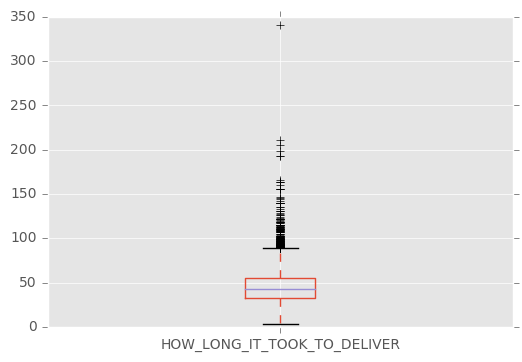

In [774]:
df['HOW_LONG_IT_TOOK_TO_DELIVER'].plot(kind='box')

In [777]:
jumpman_df.mean()

AVG_DELIVERY_TIME    46.760270
DELIVERIES           10.323529
AVG_DISTANCE          1.138453
dtype: float64

In [785]:
df.columns

Index([u'customer_id', u'jumpman_id', u'vehicle_type', u'place_category',
       u'item_name', u'item_quantity', u'item_category_name',
       u'how_long_it_took_to_order', u'pickup_lat', u'pickup_lon',
       u'dropoff_lat', u'dropoff_lon', u'when_the_delivery_started',
       u'when_the_Jumpman_arrived_at_pickup', u'when_the_Jumpman_left_pickup',
       u'when_the_Jumpman_arrived_at_dropoff', u'HOW_LONG_IT_TOOK_TO_DELIVER',
       u'PICKUP_PLACE_CLEAN', u'PICKUP_LAT_LON', u'DROPOFF_LAT_LON',
       u'DISTANCE'],
      dtype='object')

#linear regression model, lets find out if we can predict some of why deliveries take so long

In [797]:
df = df.set_index('delivery_id')

KeyError: 'delivery_id'

In [798]:
#lets turn vehicles in Dummy variables for a model

In [799]:
df_vehicle_type = pd.get_dummies(df.vehicle_type,dummy_na=True, prefix = 'vehicle')

In [801]:
df_vehicle_type['four_wheels'] = df_vehicle_type.vehicle_car + df_vehicle_type.vehicle_truck + df_vehicle_type.vehicle_van

In [802]:
df_vehicle_type['two_wheels'] = df_vehicle_type.vehicle_bicycle + df_vehicle_type.vehicle_motorcycle + df_vehicle_type.vehicle_scooter

In [805]:
df_vehicle_type.drop(['vehicle_car','vehicle_truck','vehicle_van','vehicle_bicycle','vehicle_motorcycle','vehicle_scooter'],axis=1,inplace=True)

In [810]:
df_vehicle_type.vehicle_nan.sum()

0.0

In [808]:
df = df.join(df_vehicle_type)

In [838]:
df.drop(['vehicle_nan'],axis=1,inplace=True)

In [868]:
X_names = [
    'item_quantity',
    'DISTANCE',
    'four_wheels',
    'two_wheels'
]
#df_train = df.dropna(subset = ['item_quantity'])
X = df[X_names]
y = df.HOW_LONG_IT_TOOK_TO_DELIVER

In [840]:
X.isnull().sum()

DISTANCE       0
four_wheels    0
two_wheels     0
dtype: int64

In [841]:
def summary(X, y, model):
    _, f_pvalues = feature_selection.f_regression(X, y)

    print 'R^2 =', model.score(X, y)
    print

    print 'Coefficients'
    print '- beta_0 (Intercept) = {}'.format(model.intercept_)

    for i, coef in enumerate(model.coef_):
        print '- beta_{} ({}) = {} (p-value = {})'.format(i + 1, X.columns[i], coef, f_pvalues[i])

In [842]:
model = linear_model.LinearRegression().fit(X, y)
summary(X, y, model)
model.score(X, y)

R^2 = 0.138300601551

Coefficients
- beta_0 (Intercept) = 40.6759700753
- beta_1 (DISTANCE) = 7.30788918502 (p-value = 5.79416353584e-234)
- beta_2 (four_wheels) = 2.44626699726 (p-value = 7.00147050204e-53)
- beta_3 (two_wheels) = -2.64961247564 (p-value = 1.2226534868e-50)


0.13830060155113311

In [843]:
df.head()

customer_id  jumpman_id vehicle_type     place_category  \
delivery_id                                                            
1271706            66556      154943          car                NaN   
1271751           104131      124897      bicycle         Drug Store   
1271867           121706      124897      bicycle          Fast Food   
1272279           304449      112830      bicycle           American   
1272303           107621      127812      bicycle  Convenience Store   

                      item_name  item_quantity item_category_name  \
delivery_id                                                         
1271706                     NaN            NaN                NaN   
1271751                     NaN            NaN                NaN   
1271867      World Famous Fries            2.0     Snacks & Sides   
1272279                   Bacon            1.0              Sides   
1272303                     NaN            NaN                NaN   

             how_long_it_took_to_order  pickup_lat    ...      \
delivery_id                                           ...       
1271706                            NaN   40.744157    ...       
1271751                            NaN   40.763217    ...       
1271867                            NaN   40.756799    ...       
1272279                       9.133333   40.736794    ...       
1272303                            NaN   40.743171    ...       

             when_the_Jumpman_arrived_at_dropoff  HOW_LONG_IT_TOOK_TO_DELIVER  \
delivery_id                                                                     
1271706               2014-10-01 00:30:21.109149                    22.366667   
1271751               2014-10-01 01:04:14.355157                    37.700000   
1271867               2014-10-01 01:49:29.034932                    49.366667   
1272279               2014-10-01 09:28:40.095456                    42.400000   
1272303               2014-10-01 09:39:41.631246                    19.333333   

                PICKUP_PLACE_CLEAN                   PICKUP_LAT_LON  \
delivery_id                                                           
1271706               CVS PHARMACY  (40.7441574576, -73.9919873573)   
1271751                DUANE READE  (40.7632166233, -73.9676127988)   
1271867                 MCDONALD'S  (40.7567986979, -73.9878988266)   
1272279         FRIEND OF A FARMER  (40.7367940361, -73.9867997455)   
1272303      DUANE READE DUPLICATE      (40.74317142, -73.98400362)   

                             DROPOFF_LAT_LON  DISTANCE vehicle_walker  \
delivery_id                                                             
1271706              (40.744079, -73.991519)  0.025169            0.0   
1271751              (40.76534, -73.9671058)  0.148914            0.0   
1271867             (40.756804, -73.9981532)  0.538056            0.0   
1272279      (40.7330196032, -73.9824362269)  0.346825            0.0   
1272303              (40.744964, -73.985617)  0.149897            0.0   

             four_wheels two_wheels  
delivery_id                          
1271706              1.0        0.0  
1271751              0.0        1.0  
1271867              0.0        1.0  
1272279              0.0        1.0  
1272303              0.0        1.0  

[5 rows x 24 columns]

In [870]:
X_names = [
    'how_long_it_took_to_order',
    'DISTANCE',
    'four_wheels',
    'two_wheels'
]
df_train = df.dropna(subset = ['how_long_it_took_to_order'])
X = df_train[X_names]
y = df_train.HOW_LONG_IT_TOOK_TO_DELIVER
model = linear_model.LinearRegression().fit(X, y)
summary(X, y, model)
model.score(X, y)

R^2 = 0.36701570231

Coefficients
- beta_0 (Intercept) = 33.7362821601
- beta_1 (how_long_it_took_to_order) = 1.21070585634 (p-value = 2.75215807377e-153)
- beta_2 (DISTANCE) = 7.83020113602 (p-value = 1.35914771263e-228)
- beta_3 (four_wheels) = -5.21816873051 (p-value = 4.19248081625e-21)
- beta_4 (two_wheels) = -5.78213808407 (p-value = 1.20456641824e-27)


0.36701570231017289

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x30c27ab90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x33908d6d0>]], dtype=object)

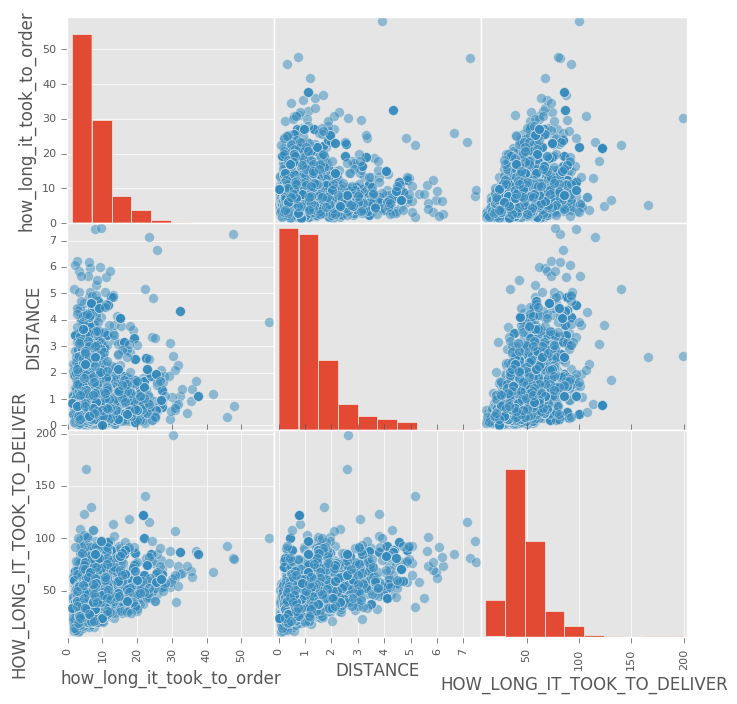

In [851]:
pd.tools.plotting.scatter_matrix(df_train[['how_long_it_took_to_order','DISTANCE','HOW_LONG_IT_TOOK_TO_DELIVER']], s = 200, figsize = (8, 8))

In [852]:
df.columns

Index([u'customer_id', u'jumpman_id', u'vehicle_type', u'place_category',
       u'item_name', u'item_quantity', u'item_category_name',
       u'how_long_it_took_to_order', u'pickup_lat', u'pickup_lon',
       u'dropoff_lat', u'dropoff_lon', u'when_the_delivery_started',
       u'when_the_Jumpman_arrived_at_pickup', u'when_the_Jumpman_left_pickup',
       u'when_the_Jumpman_arrived_at_dropoff', u'HOW_LONG_IT_TOOK_TO_DELIVER',
       u'PICKUP_PLACE_CLEAN', u'PICKUP_LAT_LON', u'DROPOFF_LAT_LON',
       u'DISTANCE', u'vehicle_walker', u'four_wheels', u'two_wheels'],
      dtype='object')

In [857]:
df['DAY_OF_WEEK'] = [df.when_the_delivery_started.iloc[i].dayofweek for i in range(len(df.when_the_delivery_started))]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x339dbc450>]], dtype=object)

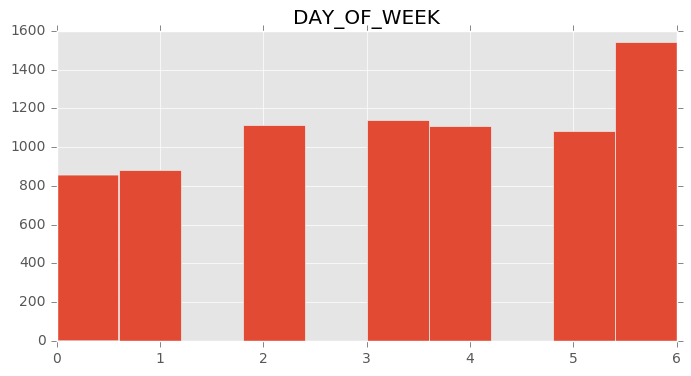

In [862]:
df[ ['DAY_OF_WEEK'] ].hist(figsize = (8, 4))

In [860]:
df['DAY_OF_WEEK'].value_counts()

6    1545
3    1142
2    1115
4    1107
5    1085
1     881
0     856
Name: DAY_OF_WEEK, dtype: int64